<a href="https://colab.research.google.com/github/fkhandley/MSDS696_PracticumII/blob/main/MSDS696_Practicum_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and connect to Google Drive

In [ ]:
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
import statsmodels.api as sm
from google.colab import files
from google.colab import drive
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Analysis Default settings

In [ ]:
# Not used in Mode Analytics impelentation
def_cluster_dimension = 'product_subcategory'
def_min_cluster = 2
def_max_cluster = 5
def_grouping = ['date', 'location_name', 'barcode']
dimensions = [
    'location_name',
    'product_category',
    'product_subcategory',
    'top_brand',
    'price_tier_product_category',
    'price_tier_product_subcategory',
    'month',
    'period',
    'hour'
    ]

# Defined Functions for preparing the primary dataframe

In [ ]:
# For pulling the effective list price per unit regardless of bulk deals
def extract_price(text):
    # Convert to string in case the input is not already a string
    if not isinstance(text, str):
        return "No Price"

    # Step 1: Look for 'ProductPrice' pattern for single unit sales
    product_price_match = re.search(r'"ProductPrice":(\d+\.\d+)', text)
    if product_price_match:
        return float(product_price_match.group(1))

    # Step 2: Look for 'Price' pattern when 'ProductPrice' does not exist, applies to bulk pricing strucutre
    price_match = re.search(r'"Price":(\d+\.\d+)', text)
    if price_match:
        return float(price_match.group(1))

    # Return 'No Price' if no pattern matches
    return "No Price"

In [ ]:
# Feature Creation: Brand name if brand is in top five unit sales for the subcategory otherwise 'Other'
def add_category_brand_column(df):
    # Create a copy of the dataframe to avoid warnings
    result_df = df.copy()

    # Get the top 5 brands by unit sales for each subcategory
    top_brands_by_subcategory = {}

    for subcategory in df['subcategory'].unique():
        subcategory_df = df[df['subcategory'] == subcategory]
        brand_sales = subcategory_df.groupby('brand')['sales_qty'].sum().reset_index()
        top_brands = brand_sales.sort_values('sales_qty', ascending=False).head(5)['brand'].tolist()
        top_brands_by_subcategory[subcategory] = top_brands

    # Create the new column with brand/other
    def create_label(row):
        subcategory = row['subcategory']
        brand = row['brand']

        # Check if this brand is in the top 5 for its subcategory
        if brand in top_brands_by_subcategory[subcategory]:
            return brand
        else:
            return "Other"

    # Apply the function to create the new column and return the dataframe
    result_df['top_brand'] = result_df.apply(create_label, axis=1)

    return result_df

# Import csv into dataframe and perform data prep

In [ ]:
sales_load = pd.read_csv('/content/drive/MyDrive/co_sales.csv')
sales_load['unit_price'] = sales_load['price_json'].apply(extract_price) # Get the list price from the menu
sales_load = sales_load[sales_load['sales_qty'] > 0 ] # remove rare negative items sales, might be returns?

In [ ]:
sales_load = add_category_brand_column(sales_load) #Add column of top 5 brands by subcategory

In [ ]:
#Remove small immaterial subcategories for improved visualization
subcat_count = sales_load.groupby('subcategory')['sales_qty'].sum().reset_index()
subcat_count['total_units'] = sales_load.sales_qty.sum()
subcat_count['ratio'] = subcat_count['sales_qty'] / subcat_count['total_units']
subcat_drop = subcat_count[subcat_count['ratio'] < .005].subcategory.tolist() # Droping subcategories that are less than 0.5% of unit sales
sales_load = sales_load[~sales_load['subcategory'].isin(subcat_drop)]

In [ ]:
# Calculate discount %
sales_load['discount_percentage'] = (sales_load['unit_discount'] / sales_load['unit_price'])*100

In [ ]:
# Datetime features
sales_load['datetime'] = pd.to_datetime(sales_load['datetime'])
sales_load['hour'] = sales_load.datetime.dt.hour.apply(lambda x: f'{x:02d}')
sales_load['year'] = sales_load.datetime.dt.year
sales_load['month'] = sales_load.datetime.dt.month
sales_load['period'] = sales_load.year.astype(str) + " - " + sales_load.month.astype(str)
sales_load['date'] = sales_load.datetime.dt.date
sales_load['day_of_week'] = sales_load.datetime.dt.dayofweek.astype(str) + ": " + sales_load.datetime.dt.day_name()

In [ ]:
# Rename for more intuitive labeling
sales_load.rename({'full_name':'product_full_name',
  'brand':'product_brand',
  'category':'product_category',
  'subcategory':'product_subcategory',
  'store':'location_name',
  'sales_qty':'units_sold',
},axis=1, inplace=True)

# Remove any unused features
sales = sales_load[['trans_id',
  'datetime',
  'barcode',
  'product_full_name',
  'product_category',
  'product_subcategory',
  'top_brand',
  'location_name',
  'units_sold',
  'unit_price',
  'unit_discount',
  'discount_percentage',
  'year',
  'month',
  'hour',
  'day_of_week',
  'date',
  'period'
]]

# Remove records where discount rate is above 40% assuming these are employee give aways or customer service based and would skew results
sales = sales[ (sales['discount_percentage']<40) & (sales['unit_price'] > 2)].copy()

# Defined functions for performing analysis


In [ ]:
# Group by defined criteria (default day/location/product) to reduce data size
def group_data(df= sales, grouping = def_grouping):
    df = sales.copy()

    grouped_df = df.groupby(grouping).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'hour': 'first', #!!!!THIS WONT WORK!! Need to change the grouping to include hour
        'period': 'first',
        'trans_id': 'count'  # This gives you transaction count per group
    }).reset_index()

    # Calculate effective price (unit net sales price before tax and loyalty point application)
    grouped_df['effective_price'] = grouped_df['unit_price'] - grouped_df['unit_discount']

    # Calculate net sales per row
    grouped_df['net_sales'] = grouped_df['units_sold'] * grouped_df['effective_price']

    # Rename trans_id to transaction_count for clarity
    grouped_df.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

    return grouped_df

In [ ]:
# Create clusters by list price: Allow for elasticity analysis at different price points, map to the median price for easy application of price changes
def price_cluster(df, cluster_dim, min_clusters=def_min_cluster, max_clusters=def_max_cluster):
    df = df.copy()
    cluster_info = {}

     # Filter out small dimensions
    dimension_counts = df[cluster_dim].value_counts()
    valid_dimensions = dimension_counts[dimension_counts >= 1000].index

    if len(valid_dimensions) == 0:
        #print("Warning: No dimensions have 1000+ data points. Consider lowering the threshold.")
        return df, cluster_info  # Return the df as is

    # Analyze price variability across all dimensions
    variability_stats = {}
    for dimension in valid_dimensions:
        prices = df[df[cluster_dim] == dimension]['unit_price']

        # Skip if no valid prices
        if len(prices) == 0 or prices.isna().all():
            #print(f"  Skipping {dimension} - No valid prices found")
            continue

        # Calculate statistics that reflect price spread/variability
        stats = {
            'count': len(prices),
            'min': prices.min(),
            'max': prices.max(),
            'mean': prices.mean(),
            'median': prices.median(),
            'std': prices.std(),
            'iqr': prices.quantile(0.75) - prices.quantile(0.25),
            'range': prices.max() - prices.min(),
            'unique_values': len(prices.unique())
        }

        # Calculate a "variability score"
        if stats['mean'] <= 0 or stats['median'] <= 0:
            #print(f"  Warning: {dimension} has zero or negative mean/median prices. Using default variability.")
            stats['variability_score'] = 0.5  # Default middle value
        else:
            cv = stats['std'] / stats['mean']
            unique_ratio = min(1.0, stats['unique_values'] / 100)  # Cap at 100 unique prices
            stats['variability_score'] = cv * unique_ratio * stats['iqr'] / stats['median']

        variability_stats[dimension] = stats

    # Check if we have any valid variability stats
    if not variability_stats:
        #print("Error: No valid price data found in any dimension. Cannot proceed with clustering.")
        return df, cluster_info

    # Get min/max variability for scaling
    var_scores = [stats['variability_score'] for stats in variability_stats.values()]
    min_var = min(var_scores)

    # Avoid division by zero if all scores are the same
    if all(score == min_var for score in var_scores):
        #print("Note: All dimensions have the same variability score. Using default clustering.")
        max_var = min_var + 1.0  # Add 1 to avoid division by zero
    else:
        max_var = max(var_scores)

    # Process each valid dimension with stats
    for dimension in variability_stats.keys():
        #print(f"Processing {dimension}...")

        # Get data for this dimension
        dimension_data = df[df[cluster_dim] == dimension]
        prices = dimension_data[['unit_price']].values

        # Determine optimal k based on price variability
        var_score = variability_stats[dimension]['variability_score']

        # Scale variability to determine k
        # If min_var equals max_var, we'll get k = min_clusters
        if min_var == max_var:
            k = min_clusters
        else:
            norm_var = (var_score - min_var) / (max_var - min_var)
            k = min_clusters + round(norm_var * (max_clusters - min_clusters))

        # Ensure k is within bounds
        k = max(min_clusters, min(max_clusters, k))

        # For transparent debugging, show the variability metrics
        stat = variability_stats[dimension]
        cv = stat['std']/stat['mean'] if stat['mean'] > 0 else 0
        iqr_ratio = stat['iqr']/stat['median'] if stat['median'] > 0 else 0
        #print(f"  Variability metrics: CV={cv:.2f}, " +
              #f"Unique prices={stat['unique_values']}, " +
              #f"IQR/Median={iqr_ratio:.2f}, " +
              #f"Score={var_score:.4f}, Selected k={k}")

        # Verify k is reasonable given the data
        n_unique = variability_stats[dimension]['unique_values']
        if n_unique < k:
            old_k = k
            k = max(min_clusters, min(k, n_unique))
            #print(f"  Adjusted k from {old_k} to {k} due to limited unique price points")

        # Clustering with the calculated k
        kmeans = KMeans(n_clusters=k, random_state=420, n_init=10)
        clusters = kmeans.fit_predict(prices.reshape(-1, 1))

        # Get cluster centers and sort them
        centers = kmeans.cluster_centers_.flatten()
        center_indices = np.argsort(centers)
        sorted_centers = centers[center_indices]

        # Create standardized cluster labels
        name = f'{cluster_dim}_price_cluster'
        df.loc[dimension_data.index, name] = clusters

        # Create labels for each cluster
        for i in range(k):
            original_idx = center_indices[i]
            center_price = sorted_centers[i]

            # Create the standardized label
            label = f"{dimension} - Cluster {i + 1} of {k} (~${center_price:.2f})"

            # Store cluster info
            cluster_key = f"{cluster_dim}_{dimension}_{original_idx}"
            cluster_info[cluster_key] = {
                'label': label,
                'center': center_price,
                'count': np.sum(clusters == original_idx),
                'cluster_number': i + 1,
                'total_clusters': k
            }

            # Map to dataframe
            mask = (df[cluster_dim] == dimension) & (df[name] == original_idx)
            df.loc[mask, f'price_tier_{cluster_dim}'] = label

    #print("Clustering complete!")
    return df, cluster_info

In [ ]:
def group_data(df, dimension):
  """
  Custom grouping based on the dimension(s) used for calculating elasticity.
  Changing the grouping will result in different elasticity results
  """
  df = df.copy()

  if dimension == 'hour':
    grouped_df = df.groupby(['hour','location_name','barcode']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()
  elif dimension[:5] == 'price' or dimension[:5] == 'combi':
        grouped_df = df.groupby(['date','location_name','barcode']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        dimension: 'first',
        'top_brand': 'first',
        'day_of_week': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()
  else:
    grouped_df = df.groupby(['date','location_name','barcode']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()

  # Calculate effective price (unit net sales price before tax and loyalty point application)
  grouped_df['effective_price'] = grouped_df['unit_price'] - grouped_df['unit_discount']

  # Calculate net sales per row
  grouped_df['net_sales'] = grouped_df['units_sold'] * grouped_df['effective_price']

  # Rename trans_id to transaction_count for clarity
  grouped_df.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

  return grouped_df


In [ ]:
def calculate_elasticity(df, dimension, min_observations=20):
  """
  Calculates relative elasticity as the slope of a regression line on a log-log scale.
  """
    results = []
    dimension_group = dimension
    df = group_data(df=df, dimension=dimension)

    # Group by the dimension
    for dimension_value, dimension_data in df.groupby(dimension):

        # Ensure we have enough data points
        if dimension_data.shape[0] < min_observations:
            continue

        try:
            # Create log values (handling zeros by adding a small constant if needed)
            small_constant = 0.001  # to avoid log(0)
            log_price = np.log(dimension_data['effective_price'] + small_constant)
            log_quantity = np.log(dimension_data['units_sold'] + small_constant)

            # Create X matrix with constant term
            X = sm.add_constant(log_price)

            # Fit regression model
            model = sm.OLS(log_quantity, X).fit()

            # Extract elasticity (coefficient for log_price)
            elasticity = model.params[1]

            # Calculate statistics for the group
            count = dimension_data.shape[0]
            avg_price = dimension_data['unit_price'].mean()
            mode_price = dimension_data['unit_price'].mode().iloc[0] if not dimension_data['unit_price'].mode().empty else avg_price
            avg_discount = dimension_data['discount_percentage'].mean()
            avg_units = dimension_data['units_sold'].mean()
            total_net_sales = round(dimension_data['net_sales'].sum(),2)
            total_units = dimension_data['units_sold'].sum()

            # Get model quality indicators
            r_squared = model.rsquared
            p_value = model.pvalues[1]  # p-value for the elasticity coefficient

            results.append({
                'dimension_group': dimension_group,
                'dimension_value': dimension_value,
                'elasticity': -elasticity,  # reverse direction to match normal convention?
                'count': count,
                'avg_price': avg_price,
                'mode_price': mode_price,
                'avg_discount': avg_discount,
                'avg_units': avg_units,
                'total_net_sales': total_net_sales,
                'total_units': total_units,
                'r_squared': r_squared,
                'p_value': p_value,
                'net_sales_share': 0  # Will be calculated later
            })
        except Exception as e:
            print(f"Error calculating elasticity for {dimension}: {str(e)}")
            continue

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # If no valid results, return empty DataFrame
    if results_df.empty:
        return pd.DataFrame(columns=['dimension', 'group', 'elasticity', 'count',
                                   'avg_price', 'mode_price', 'avg_discount', 'avg_units',
                                   'total_net_sales', 'total_units', 'r_squared',
                                   'p_value', 'net_sales_share'])

    # Calculate net_sales share
    total_dimension_net_sales = results_df['total_net_sales'].sum()
    if total_dimension_net_sales > 0:
        results_df['net_sales_share'] = (results_df['total_net_sales'] / total_dimension_net_sales) * 100

    # Sort by elasticity
    results_df = results_df.sort_values('elasticity')

    return results_df

In [ ]:
def run_analysis(df=sales):

  # Results
  all_elasticity_results = []

  # Analysis
  for dimension in dimensions:
    if dimension[:5] == 'price':
      measure = dimension[11:]  # Removing the prefix of clustured dimensions to get back to product_subcategory ro product_category from
      clus_df, ignore = price_cluster(df=df, cluster_dim = measure)
      elast_df = calculate_elasticity(df=clus_df, dimension=dimension)
    else:
      elast_df = calculate_elasticity(df=df, dimension=dimension)

    all_elasticity_results.append(elast_df)

  combined_results = pd.concat(all_elasticity_results)

  return combined_results

In [ ]:
def elasticity_interactions_visualization(df, primary_dim, secondary_dim, min_observations=20):
    """
    Used for calculated elasticity across two dimensions for plotting on a heatmap.
    """
    results = []
    df = df.copy()
    df['combined_dimension'] = df[primary_dim].astype(str) + ' x ' + df[secondary_dim].astype(str)
    combined_elasticity = calculate_elasticity(df, 'combined_dimension', min_observations)

    # Break out dimensions for plotting
    for _, row in combined_elasticity.iterrows():
        parts = row['dimension_value'].split(' x ')
        if len(parts) == 2:
            primary_val, secondary_val = parts
            results.append({
                primary_dim: primary_val,
                secondary_dim: secondary_val,
                'elasticity': row['elasticity'],
                'count': row['count'],
                'avg_price': row['avg_price'],
                'total_net_sales': row['total_net_sales']
            })

    results_df = pd.DataFrame(results)

    # Pivot for visualization
    if not results_df.empty and len(results_df) > 1:
        pivot = results_df.pivot(index=primary_dim, columns=secondary_dim, values='elasticity')

        # Visualization
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, annot=True, cmap='RdYlGn_r', center=1)
        plt.title(f'Price Elasticity: {primary_dim} x {secondary_dim}')
        plt.tight_layout()

        # For Jupyter, make sure you have this line at the top of your notebook:
        # %matplotlib inline

        plt.show()

# Analysis

In [ ]:
result = run_analysis()

In [ ]:
result.to_csv('elasticity.csv', index=False)
files.download('elasticity.csv') #Primary results file for users

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

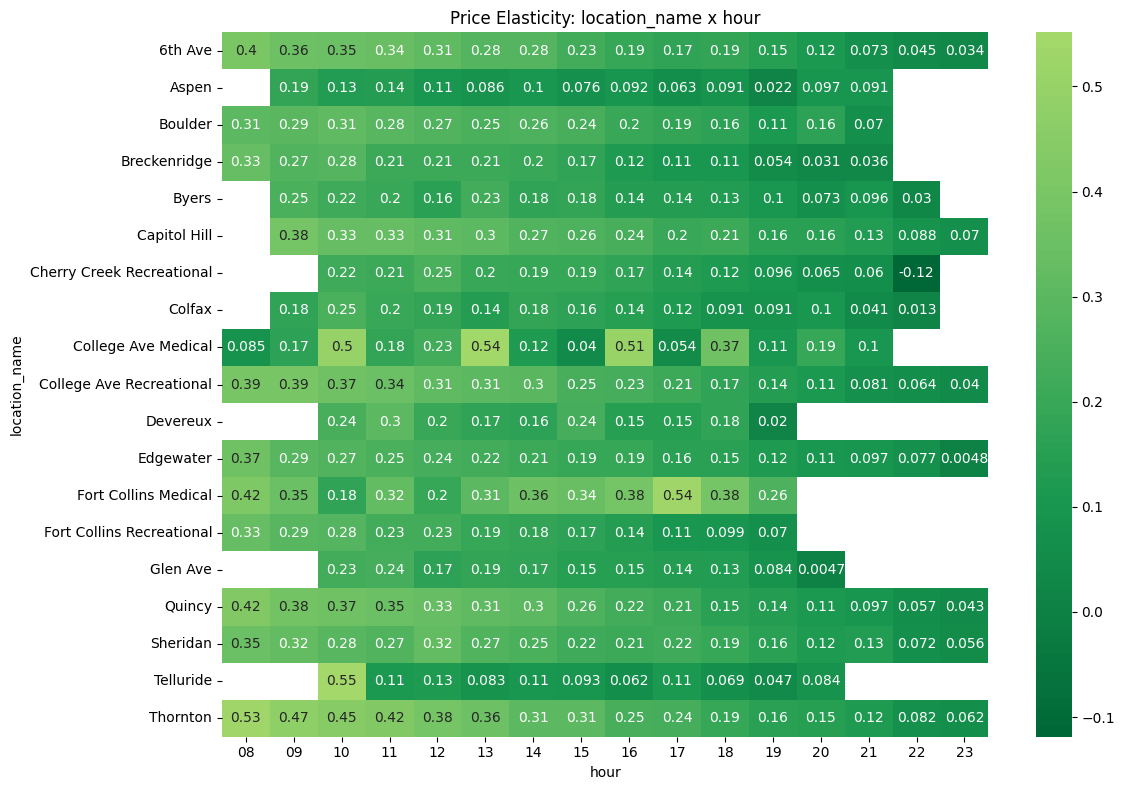

In [ ]:
# Examples of elasticity interaction plot
elasticity_interactions_visualization(sales, 'location_name','hour')

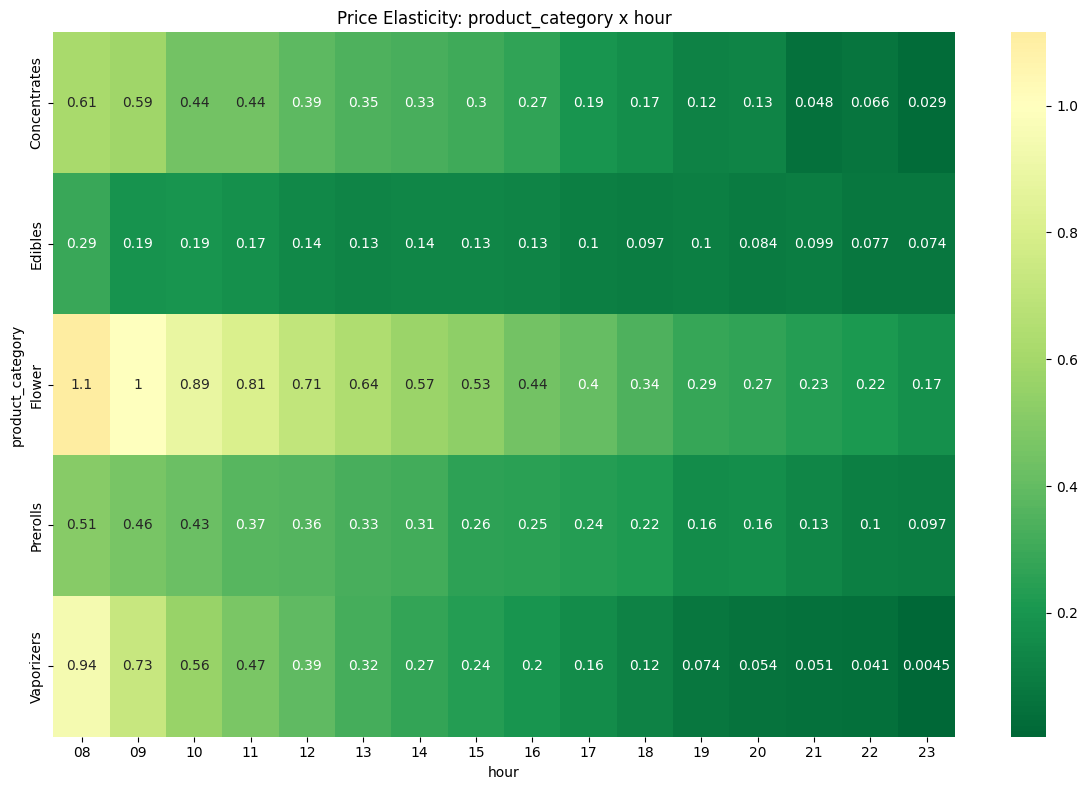

In [ ]:
elasticity_interactions_visualization(sales, 'product_category','hour')

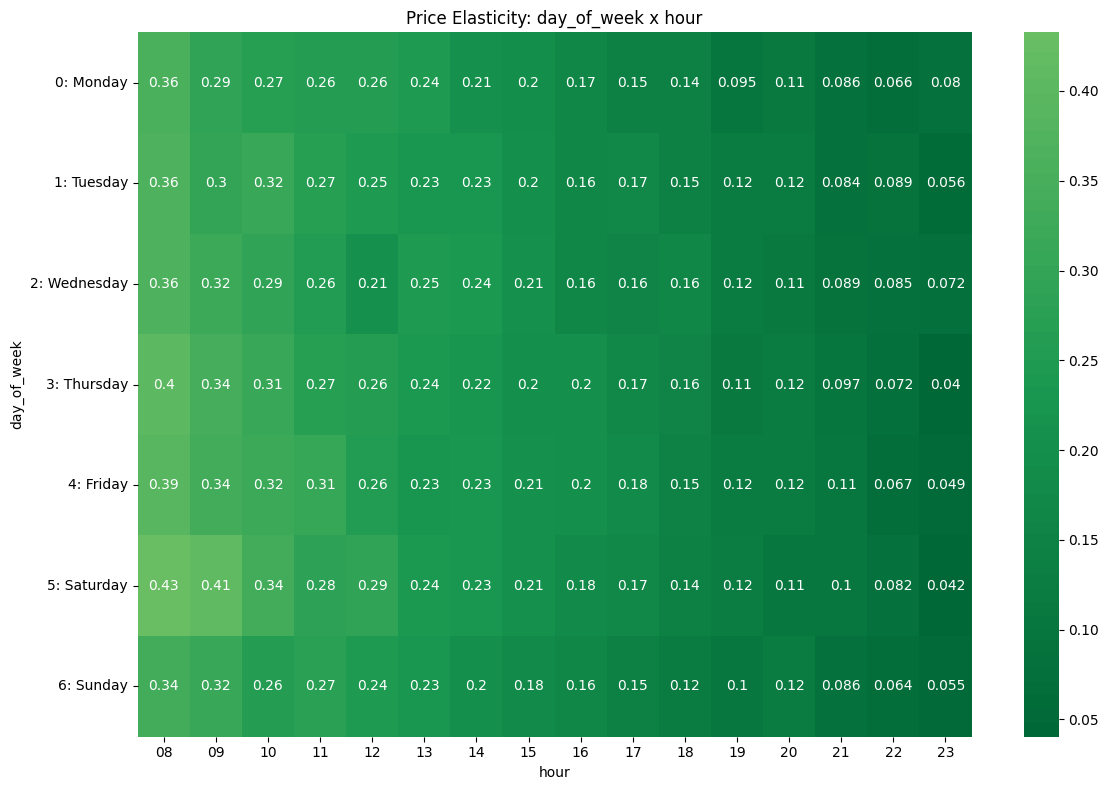

In [ ]:
elasticity_interactions_visualization(sales, 'day_of_week','hour')

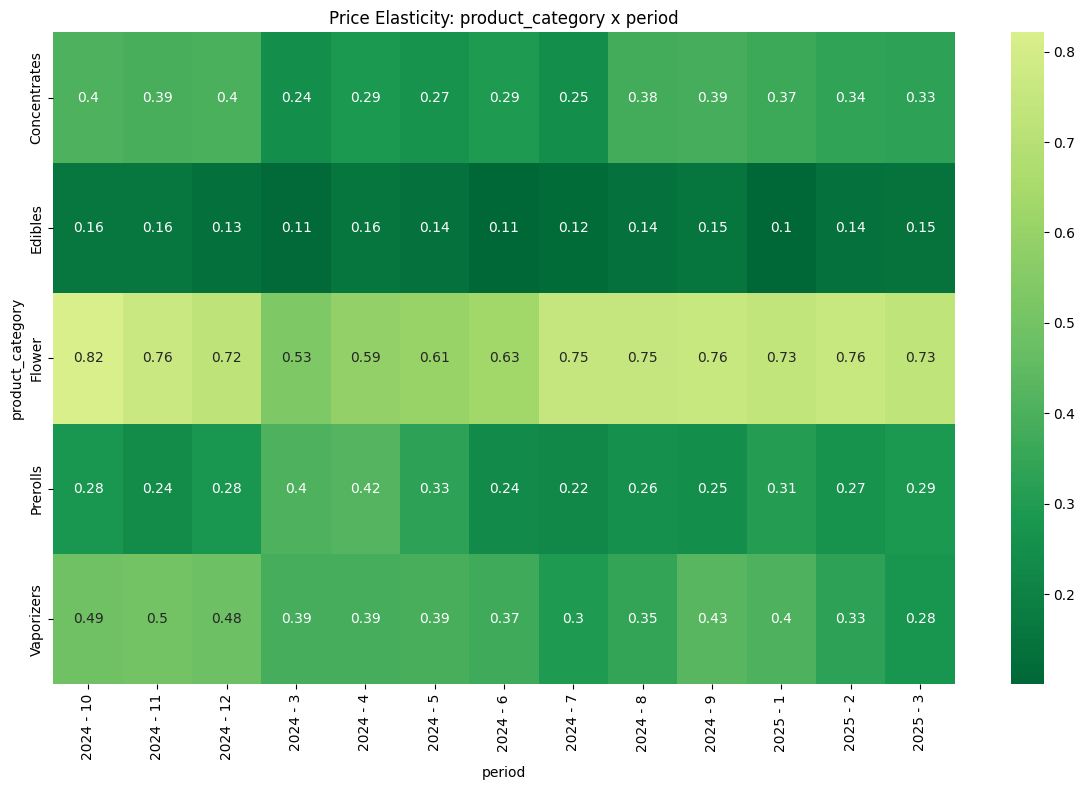

In [ ]:
elasticity_interactions_visualization(sales, 'product_category','period')

# Testing

In [ ]:
sc = sales.copy()
sc['combined_dimension'] = sc['hour'].astype(str) + ' x ' + sc['period'].astype(str)
combined_elasticity = calculate_elasticity(sc, 'combined_dimension', 20)

In [ ]:
combined_elasticity

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
196,combined_dimension,23 x 2024 - 11,0.041291,373,24.019491,29.99,9.929420,1.101877,8635.88,411.0,0.016709,1.246841e-02,0.018925
197,combined_dimension,23 x 2024 - 12,0.044771,423,24.462813,29.99,9.503504,1.137116,10222.77,481.0,0.011410,2.804240e-02,0.022403
206,combined_dimension,23 x 2025 - 2,0.046515,421,23.690713,12.99,7.550410,1.140143,10008.61,480.0,0.013880,1.557994e-02,0.021933
203,combined_dimension,23 x 2024 - 8,0.048768,512,23.890430,29.99,7.837095,1.142578,12343.46,585.0,0.015156,5.279449e-03,0.027050
202,combined_dimension,23 x 2024 - 7,0.050240,487,23.698480,29.99,6.735723,1.139630,11850.92,555.0,0.015888,5.342663e-03,0.025971
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,combined_dimension,08 x 2024 - 10,0.396699,3031,25.219327,19.99,4.898741,5.379743,329458.88,16306.0,0.056598,2.890402e-40,0.721988
17,combined_dimension,09 x 2024 - 4,0.410205,4706,23.629297,19.99,8.068425,4.698895,400959.47,22113.0,0.078319,2.047486e-85,0.878677
11,combined_dimension,08 x 2025 - 2,0.414576,2427,25.622880,19.99,5.314364,4.759374,233192.49,11551.0,0.069244,1.000408e-39,0.511027
3,combined_dimension,08 x 2024 - 3,0.438069,1982,23.446736,19.99,8.127738,5.577699,200682.17,11055.0,0.078979,2.684863e-37,0.439782


In [ ]:
result = run_analysis()

In [ ]:
result[ result['dimension_group'] == 'price_tier_product_subcategory'].sort_values('dimension_value').head(25)

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
0,price_tier_product_subcategory,All-In-One - Cluster 1 of 3 (~$29.27),-0.266077,25352,28.727575,32.99,5.231701,1.844628,1286761.86,46765.0,0.008742,2.470088e-50,2.819846
1,price_tier_product_subcategory,All-In-One - Cluster 2 of 3 (~$45.02),0.276131,25174,45.052286,44.99,5.791826,1.403710,1489396.66,35337.0,0.008311,1.330236e-47,3.263906
2,price_tier_product_subcategory,All-In-One - Cluster 3 of 3 (~$67.07),0.214446,15501,67.215340,59.99,5.623076,1.331204,1300392.00,20635.0,0.005269,1.442504e-19,2.849716
3,price_tier_product_subcategory,Badder - Cluster 1 of 2 (~$19.89),0.592023,7580,20.045937,18.99,5.445374,1.852902,262315.91,14045.0,0.018983,1.917784e-33,0.574846
4,price_tier_product_subcategory,Badder - Cluster 2 of 2 (~$33.78),0.057880,5556,33.693384,31.99,8.193655,1.264399,217154.46,7025.0,0.000799,3.510131e-02,0.475878
5,price_tier_product_subcategory,Chocolate - Cluster 1 of 2 (~$18.83),0.367383,12687,18.855532,17.99,5.599755,1.650508,369713.27,20940.0,0.008333,6.860922e-25,0.810200
6,price_tier_product_subcategory,Chocolate - Cluster 2 of 2 (~$39.12),0.368785,308,39.265974,39.99,11.418702,1.564935,16582.43,482.0,0.009682,8.470799e-02,0.036339
7,price_tier_product_subcategory,Drink - Cluster 1 of 5 (~$4.99),0.340310,15417,4.990000,4.99,6.015552,2.311669,165905.14,35639.0,0.003493,2.064167e-13,0.363569
8,price_tier_product_subcategory,Drink - Cluster 2 of 5 (~$15.64),0.177296,6896,15.597454,15.99,7.145202,1.797564,178604.46,12396.0,0.002019,1.898053e-04,0.391399
9,price_tier_product_subcategory,Drink - Cluster 3 of 5 (~$17.86),0.108262,2509,17.859271,17.99,9.273630,1.330411,53917.43,3338.0,0.001852,3.113749e-02,0.118156


In [ ]:
net_sales_share = result.groupby('dimension_group')['net_sales_share'].sum().reset_index()
net_sales_share

,dimension_group,net_sales_share
0,hour,100.0
1,location_name,100.0
2,month,100.0
3,period,100.0
4,price_tier_product_category,100.0
5,price_tier_product_subcategory,100.0
6,product_category,100.0
7,product_subcategory,100.0
8,top_brand,100.0


In [ ]:
result_cat = result[result['dimension_group'] == 'product_category'][['elasticity', 'count']]
result_subcat = result[result['dimension_group'] == 'product_subcategory'][['elasticity', 'count']]

cat_corr = result_cat.corr()
cat_elas_corr = cat_corr.loc['elasticity', 'count']

subcat_corr = result_subcat.corr()
subcat_elas_corr = subcat_corr.loc['elasticity', 'count']

print(f'category elasticity correlation to volume: {cat_elas_corr}')
print(f'subcategory elasticity correlation to volume: {subcat_elas_corr}')

category elasticity correlation to volume: -0.10335236709295273
subcategory elasticity correlation to volume: 0.39744926691852045


# Class Visual Example

Reduce data down to one item with ~2k sales records to show how elasticity is calculated and how grouping effects results.

In [ ]:
# Reduce to smaller data set
natty_flower = sales[(sales['product_category'] == 'Flower') & (sales['unit_price'] == 149.99)].copy()

In [ ]:
natty_flower.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2138 entries, 1636 to 1877421
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trans_id             2138 non-null   int64         
 1   datetime             2138 non-null   datetime64[ns]
 2   barcode              2138 non-null   object        
 3   product_full_name    2138 non-null   object        
 4   product_category     2138 non-null   object        
 5   product_subcategory  2138 non-null   object        
 6   top_brand            2138 non-null   object        
 7   location_name        2138 non-null   object        
 8   units_sold           2138 non-null   float64       
 9   unit_price           2138 non-null   float64       
 10  unit_discount        2138 non-null   float64       
 11  discount_percentage  2138 non-null   float64       
 12  year                 2138 non-null   int32         
 13  month                2138 non-nu

<Axes: >

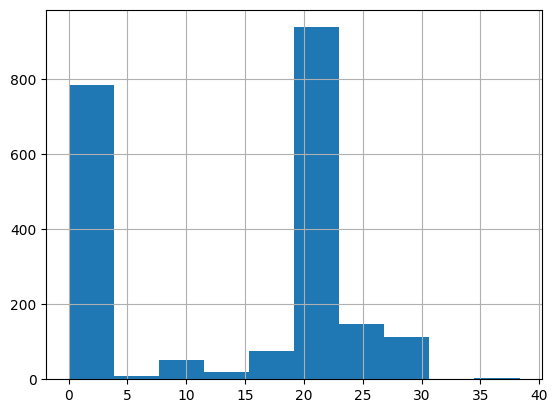

In [ ]:
# Show the distribution of discount rates on sales records
natty_flower.discount_percentage.hist()

# First grouping by date, location and barcode

Note the elasticity of 0.54

In [ ]:
# First grouping by date, location and barcode
natty_grouped1 = natty_flower.groupby(['date','location_name','barcode']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()

        # Calculate effective price (unit net sales price before tax and loyalty point application)
natty_grouped1['effective_price'] = natty_grouped1['unit_price'] - natty_grouped1['unit_discount']

  # Calculate net sales per row
natty_grouped1['net_sales'] = natty_grouped1['units_sold'] * natty_grouped1['effective_price']

  # Rename trans_id to transaction_count for clarity
natty_grouped1.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

In [ ]:
natty_grouped1.head()

,date,location_name,barcode,units_sold,unit_price,unit_discount,discount_percentage,product_full_name,product_category,product_subcategory,top_brand,year,month,period,transaction_count,effective_price,net_sales
0,2024-03-14,Breckenridge,Bruce Banner - 28g,1.0,149.99,0.0,0.000000,Natty Rems Bruce Banner 28 g,Flower,Whole Flower - 1 oz,Natty Rems,2024,3,2024 - 3,1,149.99,149.99
1,2024-03-14,Breckenridge,Triangle x Fruity OG -28 g,1.0,149.99,0.0,0.000000,Natty Rems Triangle x Fruity OG 28 g,Flower,Whole Flower - 1 oz,Natty Rems,2024,3,2024 - 3,1,149.99,149.99
2,2024-03-14,College Ave Recreational,Golden Goat - 28g,1.0,149.99,45.0,30.002000,Natty Rems Golden Goat 28 g,Flower,Whole Flower - 1 oz,Natty Rems,2024,3,2024 - 3,1,104.99,104.99
3,2024-03-14,Fort Collins Recreational,Alien Haze - 28g,1.0,149.99,30.0,20.001333,Natty Rems Alien Haze 28 g,Flower,Whole Flower - 1 oz,Natty Rems,2024,3,2024 - 3,1,119.99,119.99
4,2024-03-15,Breckenridge,Alien Haze - 28g,1.0,149.99,0.0,0.000000,Natty Rems Alien Haze 28 g,Flower,Whole Flower - 1 oz,Natty Rems,2024,3,2024 - 3,1,149.99,149.99


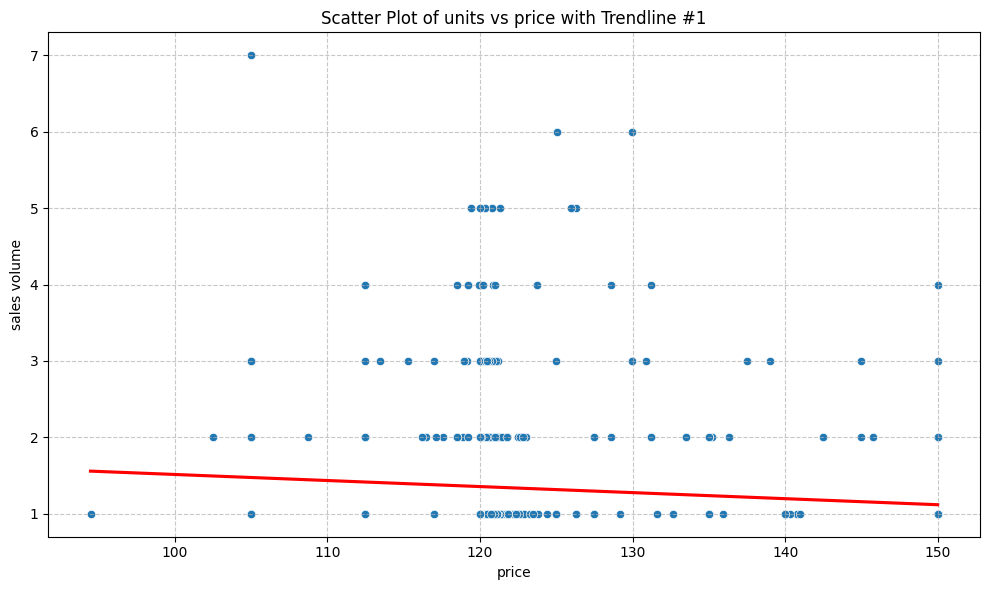

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a DataFrame called 'df' with columns 'x_variable' and 'y_variable'
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(x='effective_price', y='units_sold', data=natty_grouped1)

# Add a linear regression line
sns.regplot(x='effective_price', y='units_sold', data=natty_grouped1,
           scatter=False, ci=None, line_kws={"color": "red"})

plt.title('Scatter Plot of units vs price with Trendline #1')
plt.xlabel('price')
plt.ylabel('sales volume')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
results1 = []
small_constant = 0.001  # to avoid log(0)
log_price = np.log(natty_grouped1['effective_price'] + small_constant)
log_quantity = np.log(natty_grouped1['units_sold'] + small_constant)

# Create X matrix with constant term
X = sm.add_constant(log_price)

# Fit regression model
model = sm.OLS(log_quantity, X).fit()

 # Extract elasticity (coefficient for log_price)
elasticity = model.params[1]

            # Calculate statistics for the group
count = natty_grouped1.shape[0]
avg_price = natty_grouped1['unit_price'].mean()
mode_price = natty_grouped1['unit_price'].mode().iloc[0] if not natty_grouped1['unit_price'].mode().empty else avg_price
avg_discount = natty_grouped1['discount_percentage'].mean()
avg_units = natty_grouped1['units_sold'].mean()
total_net_sales = natty_grouped1['net_sales'].sum()
total_units = natty_grouped1['units_sold'].sum()

            # Get model quality indicators
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the elasticity coefficient

results1.append({
                'dimension_group': 'natty',
                'dimension_value': 'natty 150',
                'elasticity': -elasticity,  # reverse direction to match normal convention?
                'count': count,
                'avg_price': avg_price,
                'mode_price': mode_price,
                'avg_discount': avg_discount,
                'avg_units': avg_units,
                'total_net_sales': total_net_sales,
                'total_units': total_units,
                'r_squared': r_squared,
                'p_value': p_value,
                'net_sales_share': 0  # Will be calculated later
            })


    # Convert to DataFrame
natty_results1 = pd.DataFrame(results1)
natty_results1

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
0,natty,natty 150,0.540018,1693,149.99,149.99,12.12263,1.262847,278330.41,2138.0,0.035621,4.858925e-15,0


# Second grouping by date and barcode (location dropped)

Note the elasticity of 0.38 while the regression line looks similar still

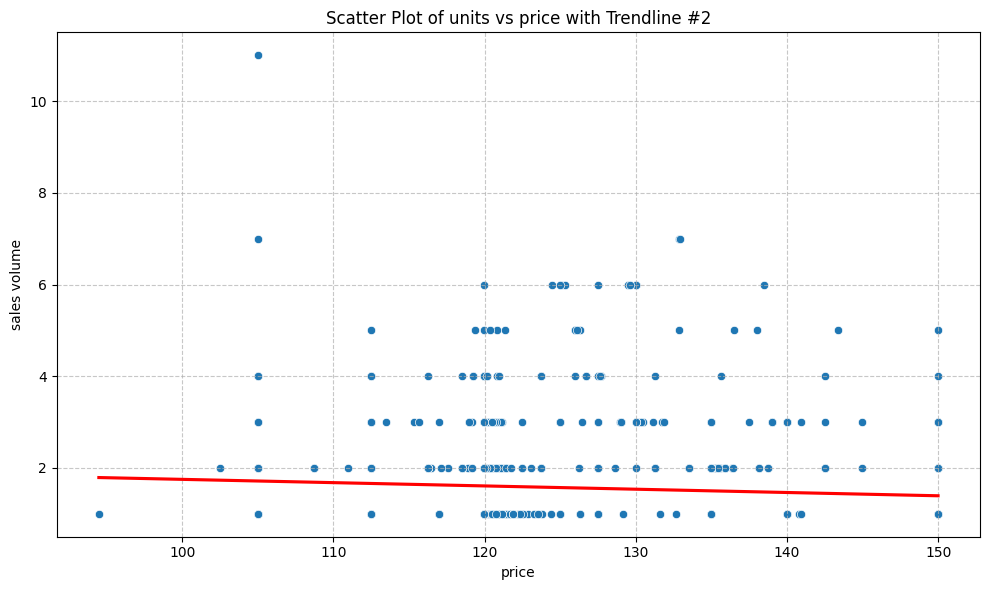

In [ ]:

natty_grouped2 = natty_flower.groupby(['date','barcode']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()

        # Calculate effective price (unit net sales price before tax and loyalty point application)
natty_grouped2['effective_price'] = natty_grouped2['unit_price'] - natty_grouped2['unit_discount']

  # Calculate net sales per row
natty_grouped2['net_sales'] = natty_grouped2['units_sold'] * natty_grouped2['effective_price']

  # Rename trans_id to transaction_count for clarity
natty_grouped2.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(x='effective_price', y='units_sold', data=natty_grouped2)

# Add a linear regression line
sns.regplot(x='effective_price', y='units_sold', data=natty_grouped2,
           scatter=False, ci=None, line_kws={"color": "red"})

plt.title('Scatter Plot of units vs price with Trendline #2')
plt.xlabel('price')
plt.ylabel('sales volume')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
results2 = []
small_constant = 0.001  # to avoid log(0)
log_price = np.log(natty_grouped2['effective_price'] + small_constant)
log_quantity = np.log(natty_grouped2['units_sold'] + small_constant)

# Create X matrix with constant term
X = sm.add_constant(log_price)

# Fit regression model
model = sm.OLS(log_quantity, X).fit()

 # Extract elasticity (coefficient for log_price)
elasticity = model.params[1]

            # Calculate statistics for the group
count = natty_grouped2.shape[0]
avg_price = natty_grouped2['unit_price'].mean()
mode_price = natty_grouped2['unit_price'].mode().iloc[0] if not natty_grouped2['unit_price'].mode().empty else avg_price
avg_discount = natty_grouped2['discount_percentage'].mean()
avg_units = natty_grouped2['units_sold'].mean()
total_net_sales = natty_grouped2['net_sales'].sum()
total_units = natty_grouped2['units_sold'].sum()

            # Get model quality indicators
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the elasticity coefficient

results2.append({
                'dimension_group': 'natty',
                'dimension_value': 'natty 150',
                'elasticity': -elasticity,  # reverse direction to match normal convention?
                'count': count,
                'avg_price': avg_price,
                'mode_price': mode_price,
                'avg_discount': avg_discount,
                'avg_units': avg_units,
                'total_net_sales': total_net_sales,
                'total_units': total_units,
                'r_squared': r_squared,
                'p_value': p_value,
                'net_sales_share': 0  # Will be calculated later
            })


    # Convert to DataFrame
natty_results2 = pd.DataFrame(results2)
natty_results2

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
0,natty,natty 150,0.374621,1400,149.99,149.99,12.485515,1.527143,278330.41,2138.0,0.008791,0.000443,0


# Third grouping by date brand/price

This removes and strain specificity in the barcode.

Note the elasticity of 1.34

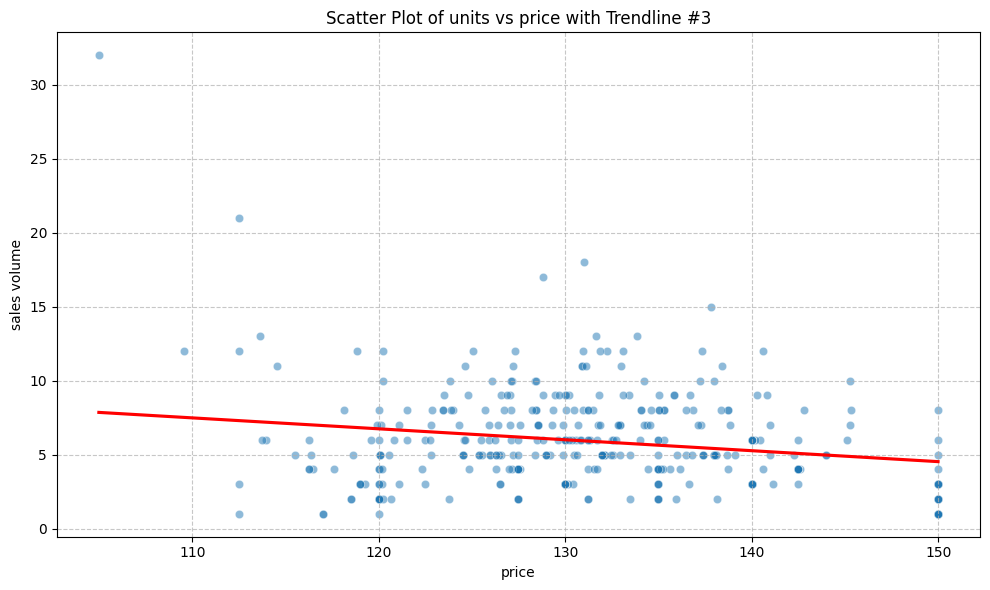

In [ ]:
natty_flower['brand_subcat_price'] = natty_flower['top_brand'] + natty_flower['product_subcategory'] + str(natty_flower['unit_price'])

natty_grouped3 = natty_flower.groupby(['date','brand_subcat_price']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()

        # Calculate effective price (unit net sales price before tax and loyalty point application)
natty_grouped3['effective_price'] = natty_grouped3['unit_price'] - natty_grouped3['unit_discount']

  # Calculate net sales per row
natty_grouped3['net_sales'] = natty_grouped3['units_sold'] * natty_grouped3['effective_price']

  # Rename trans_id to transaction_count for clarity
natty_grouped3.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(x='effective_price', y='units_sold', data=natty_grouped3, alpha=0.5)

# Add a linear regression line
sns.regplot(x='effective_price', y='units_sold', data=natty_grouped3,
           scatter=False, ci=None, line_kws={"color": "red"})

plt.title('Scatter Plot of units vs price with Trendline #3')
plt.xlabel('price')
plt.ylabel('sales volume')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
results3 = []
small_constant = 0.001  # to avoid log(0)
log_price = np.log(natty_grouped3['effective_price'] + small_constant)
log_quantity = np.log(natty_grouped3['units_sold'] + small_constant)

# Create X matrix with constant term
X = sm.add_constant(log_price)

# Fit regression model
model = sm.OLS(log_quantity, X).fit()

 # Extract elasticity (coefficient for log_price)
elasticity = model.params[1]

            # Calculate statistics for the group
count = natty_grouped3.shape[0]
avg_price = natty_grouped3['unit_price'].mean()
mode_price = natty_grouped3['unit_price'].mode().iloc[0] if not natty_grouped3['unit_price'].mode().empty else avg_price
avg_discount = natty_grouped3['discount_percentage'].mean()
avg_units = natty_grouped3['units_sold'].mean()
total_net_sales = natty_grouped3['net_sales'].sum()
total_units = natty_grouped3['units_sold'].sum()

            # Get model quality indicators
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the elasticity coefficient

results3.append({
                'dimension_group': 'natty',
                'dimension_value': 'natty 150',
                'elasticity': -elasticity,  # reverse direction to match normal convention?
                'count': count,
                'avg_price': avg_price,
                'mode_price': mode_price,
                'avg_discount': avg_discount,
                'avg_units': avg_units,
                'total_net_sales': total_net_sales,
                'total_units': total_units,
                'r_squared': r_squared,
                'p_value': p_value,
                'net_sales_share': 0  # Will be calculated later
            })


    # Convert to DataFrame
natty_results3 = pd.DataFrame(results3)
natty_results3

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
0,natty,natty 150,1.336165,361,149.99,149.99,12.57879,5.922438,278330.41,2138.0,0.024432,0.002902,0


# First example with the same grouping as the third but with the plot on log scale

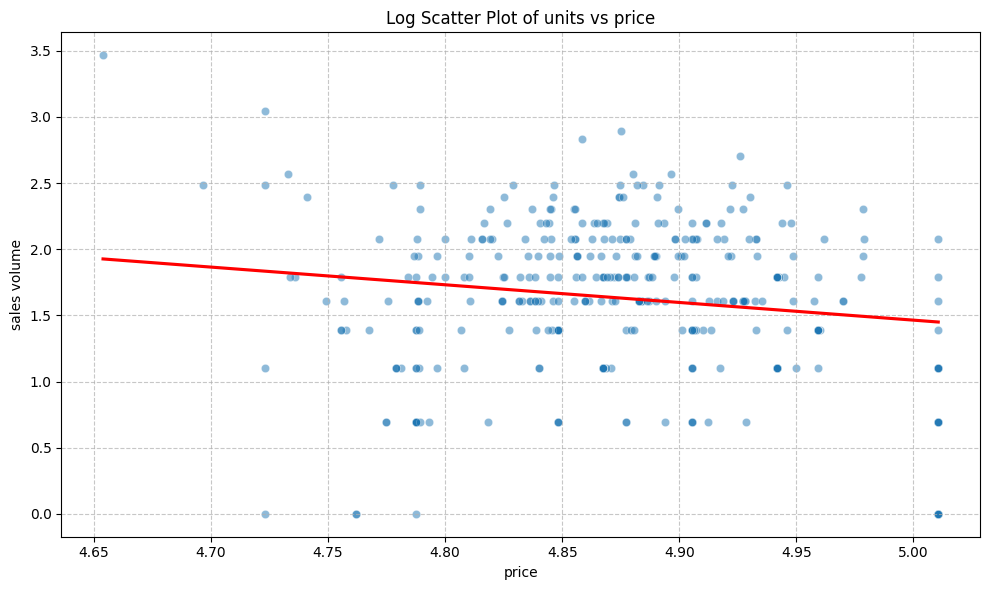

In [ ]:
natty_flower['brand_subcat_price'] = natty_flower['top_brand'] + natty_flower['product_subcategory'] + str(natty_flower['unit_price'])

natty_grouped4 = natty_flower.groupby(['date','brand_subcat_price']).agg({
        'units_sold': 'sum',
        'unit_price': 'mean',
        'unit_discount': 'mean',
        'discount_percentage': 'mean',
        'product_full_name': 'first',
        'product_category': 'first',
        'product_subcategory': 'first',
        'top_brand': 'first',
        'year': 'first',
        'month': 'first',
        'period': 'first',
        'trans_id': 'count'
      }).reset_index()

        # Calculate effective price (unit net sales price before tax and loyalty point application)
natty_grouped4['effective_price'] = natty_grouped4['unit_price'] - natty_grouped4['unit_discount']

  # Calculate net sales per row
natty_grouped4['net_sales'] = natty_grouped4['units_sold'] * natty_grouped4['effective_price']

  # Rename trans_id to transaction_count for clarity
natty_grouped4.rename(columns={'trans_id': 'transaction_count'}, inplace=True)

natty_grouped4['log_effective_price'] = np.log(natty_grouped4['effective_price'] + small_constant)
natty_grouped4['log_units_sold'] = np.log(natty_grouped4['units_sold'] + small_constant)

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(x='log_effective_price', y='log_units_sold', data=natty_grouped4, alpha=0.5)

# Add a linear regression line
sns.regplot(x='log_effective_price', y='log_units_sold', data=natty_grouped4,
           scatter=False, ci=None, line_kws={"color": "red"})

plt.title('Log Scatter Plot of units vs price')
plt.xlabel('price')
plt.ylabel('sales volume')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
results4 = []
small_constant = 0.001  # to avoid log(0)
log_price = np.log(natty_grouped4['effective_price'] + small_constant)
log_quantity = np.log(natty_grouped4['units_sold'] + small_constant)

# Create X matrix with constant term
X = sm.add_constant(log_price)

# Fit regression model
model = sm.OLS(log_quantity, X).fit()

 # Extract elasticity (coefficient for log_price)
elasticity = model.params[1]

            # Calculate statistics for the group
count = natty_grouped4.shape[0]
avg_price = natty_grouped4['unit_price'].mean()
mode_price = natty_grouped4['unit_price'].mode().iloc[0] if not natty_grouped4['unit_price'].mode().empty else avg_price
avg_discount = natty_grouped4['discount_percentage'].mean()
avg_units = natty_grouped4['units_sold'].mean()
total_net_sales = natty_grouped4['net_sales'].sum()
total_units = natty_grouped4['units_sold'].sum()

            # Get model quality indicators
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the elasticity coefficient

results4.append({
                'dimension_group': 'natty',
                'dimension_value': 'natty 150',
                'elasticity': -elasticity,  # reverse direction to match normal convention?
                'count': count,
                'avg_price': avg_price,
                'mode_price': mode_price,
                'avg_discount': avg_discount,
                'avg_units': avg_units,
                'total_net_sales': total_net_sales,
                'total_units': total_units,
                'r_squared': r_squared,
                'p_value': p_value,
                'net_sales_share': 0  # Will be calculated later
            })


    # Convert to DataFrame
natty_results4 = pd.DataFrame(results4)
natty_results4

,dimension_group,dimension_value,elasticity,count,avg_price,mode_price,avg_discount,avg_units,total_net_sales,total_units,r_squared,p_value,net_sales_share
0,natty,natty 150,1.336165,361,149.99,149.99,12.57879,5.922438,278330.41,2138.0,0.024432,0.002902,0
